<a href="https://colab.research.google.com/github/Veronicarx77/441B-1/blob/main/Week_7_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.) Import an asset price from Yahoo Finance

In [4]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.2/111.2 KB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 71.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 KB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 5.6 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
   

In [26]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout


########################################
####Pick your ticker and time period####
########################################
stock_data = yf.download("LULU", start="2013-02-23", end="2023-02-23")



# Preprocess data
scaled_data = np.array(stock_data["Close"].pct_change().dropna()).reshape(-1,1)


# Split data into training and test sets
training_data_len = int(len(scaled_data) * 0.8)
train_data = scaled_data[0:training_data_len, :]



[*********************100%***********************]  1 of 1 completed


# 2.) Create your x_train/y_train data so that your RNN uses percentage change data to make a binary forecast where the stock moves up or down the next day
# Build an RNN Architecture accordingly

In [39]:
x_train = []
y_train = []


#############################################################
####Pick your input size and edit to make binary forecast####. ## did the stock move up or down 'tomorrow'?
#############################################################
input_size = 4
for i in range(input_size, len(train_data)):
    x_train.append(train_data[i-input_size:i, 0])
    if train_data[i, 0] > 0:
      y_train.append(1) 
    else:
      y_train.append(0) 
      # if y_train is greater than 0 -> y_train = 1; less than 0 -> y_train = 0


x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

###################################
####Build Your RNN Architecture####
###################################
model = Sequential()
model.add(LSTM(x_train.shape[1], return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(30, return_sequences=False))
model.add(Dense(10))
model.add(Dense(1))

# Classification 
# activation function - whether you need a threshold? if you use the 'unit step' you don't need the threshold, the function will do it for you, 
# relocate the value to 0 or 1


model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=1, epochs=3)

Epoch 1/3
2008/2008 [==============================] - 16s 5ms/step - loss: 0.2578
Epoch 2/3
2008/2008 [==============================] - 9s 5ms/step - loss: 0.2525
Epoch 3/3
2008/2008 [==============================] - 11s 5ms/step - loss: 0.2532


# 3.) Test your model and compare insample Accurracy, insample random walk assumption Accuracy, Out of sample Accuracy and out of sample random walk assumption Accuracy using a bar chart

In [40]:
from matplotlib.collections import EllipseCollection

test_data = scaled_data[training_data_len - input_size:, :]

x_test = []
y_test = np.array(stock_data[["Close"]].pct_change().dropna())[training_data_len:, :]
for i in range(input_size, len(test_data)):
    x_test.append(test_data[i-input_size:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

for i in range(0,len(y_test)):
  if y_test[i]>0:
    y_test[i] = 1
  else:
    y_test[i] = 0

y_test = np.array(y_test)

predictions = model.predict(x_test)


16/16 [==============================] - 1s 4ms/step


In [41]:
import numpy as np
# in sample - use the train data 

pred_in_sample = model.predict(x_train)
rmse_in = np.sqrt(np.mean(pred_in_sample - y_train)**2)
print('In sample RMSE:',rmse_in)

rmse_in_rw = np.sqrt(np.mean(y_train)**2)
print('In sample random walk RMSE:',rmse_in_rw)

# out of sample -  random walk
#y_test[1:] #actual
#y_test[:-1] #prediction

rmse_out = np.sqrt(np.mean(predictions - y_test)**2)
print('Out of sample RMSE:',rmse_out)

rmse_out_rw = np.sqrt(np.mean(y_test)**2)
print('Out of sample random walk RMSE:',rmse_out_rw)

63/63 [==============================] - 0s 3ms/step
In sample RMSE: 0.020051003600734165
In sample random walk RMSE: 0.5184262948207171
Out of sample RMSE: 0.0226004392145172
Out of sample random walk RMSE: 0.5158730158730159


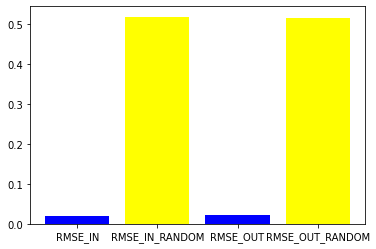

In [42]:
# make a barchart # mse, rmse
import matplotlib.pyplot as plt
plt.bar(['RMSE_IN'],[rmse_in],color = 'blue')
plt.bar(['RMSE_IN_RANDOM'],[rmse_in_rw],color = 'yellow')
plt.bar(['RMSE_OUT'],[rmse_out],color = 'blue')
plt.bar(['RMSE_OUT_RANDOM'],[rmse_out_rw],color = 'yellow')
plt.show()

# 4.) Plot in and out of sample accuracy

16/16 [==============================] - 0s 3ms/step


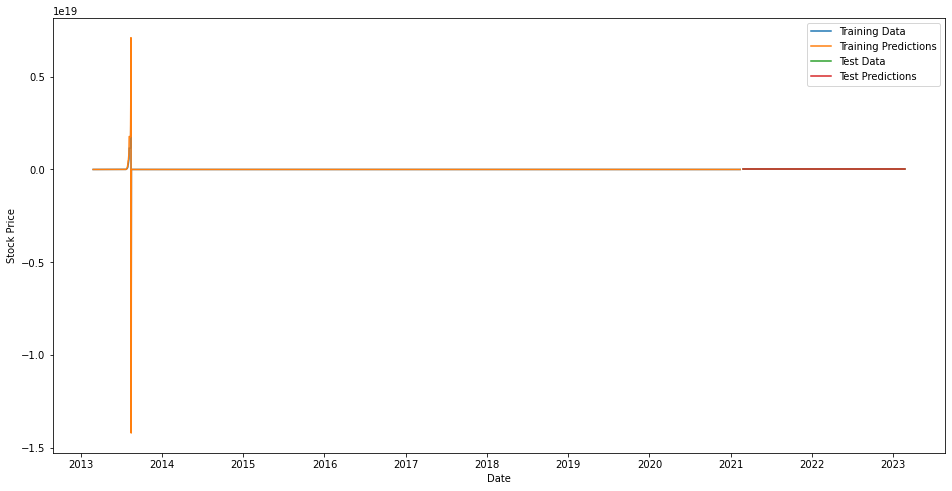

In [43]:
import matplotlib.pyplot as plt

# Make predictions on full dataset

test_predict = model.predict(x_test)
test_predictions = (test_predict+1).reshape(1,-1) * np.cumprod(y_test+1)

train_predict = model.predict(x_train)

train_predictions = (train_predict+1).reshape(1,-1) * np.cumprod(y_train+1)


fig = plt.figure(figsize = (16,8))
plt.plot(stock_data[:training_data_len- input_size].index, np.cumprod(y_train+1), label="Training Data")
plt.plot(stock_data[:training_data_len- input_size].index, train_predictions[0], label="Training Predictions")
end_val = np.cumprod(y_train+1)[-1]
test_predict = model.predict(x_test)
test_predictions = (test_predict+1).reshape(1,-1) * (np.cumprod((y_test+1))*end_val)
plt.plot(stock_data[training_data_len+1:].index, np.cumprod((y_test+1))*end_val,label="Test Data")
plt.plot(stock_data[training_data_len+1:].index, test_predictions[0], label="Test Predictions")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

#5.) Write an observation/conclusion about the graphs from Q4 and Q3

In [ ]:
# The LSTM model perfroms much better than the random walk on the same sample, with much lower RMSE both in-sample and out of sample.

# 6.) Create a parameter for number of lags in your input layer. Do a 3-fold CV to test three different time lags. i.e. Tested using 5,10,20 days of previous price data to forecast

In [2]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.wrappers.scikit_learn import KerasRegressor

In [11]:
def create_model(neurons,lags):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(lags, 1)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
    return model

lags = [5,10,20]

# Define a dictionary of parameter values to try
param_grid = {
    # 'lags': lags,
    'batch_size':[10,20,100],
    'epochs':[1],
    'neurons':[5,10,20]
}

for lag in lags:
  model = KerasRegressor(build_fn=create_model,lags=lag)
  grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1,)
  X = np.array([train_data[i:i+lag] for i in range(len(train_data)-lag)])
  y = np.array([train_data[i+lag] for i in range(len(train_data)-lag)])
  grid.fit(X, y)

# print the best hyperparameters and their score
  print('lag:',lag)
  print(f'Best params: {grid.best_params_}')
  print(f'Best score: {grid.best_score_:.4f}')



<ipython-input-11-8695bbb91466>:19: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model,lags=lag)


201/201 [==============================] - 5s 8ms/step - loss: 0.1962 - accuracy: 0.0030
lag: 5
Best params: {'batch_size': 10, 'epochs': 1, 'neurons': 20}
Best score: -0.0112
201/201 [==============================] - 5s 7ms/step - loss: 0.1414 - accuracy: 0.0030
lag: 10
Best params: {'batch_size': 10, 'epochs': 1, 'neurons': 20}
Best score: -0.0101
200/200 [==============================] - 6s 10ms/step - loss: 0.1357 - accuracy: 0.0030
lag: 20
Best params: {'batch_size': 10, 'epochs': 1, 'neurons': 20}
Best score: -0.0107


In [15]:
# when lag = 10, the actual value of the loss function is the smallest, thus has the best performance.
# best model: lag = 10, batch_size = 10, epochs = 1, neurons = 20

best_model = KerasRegressor(build_fn = create_model,neurons = 20, lags = 10, batch_size = 10, epochs = 1)

<ipython-input-15-050a2ad8b86a>:4: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  best_model = KerasRegressor(build_fn = create_model,neurons = 20, lags = 10, batch_size = 10, epochs = 1)
